In [1]:
import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y


In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, activation
from tensorflow.keras import layers

In [4]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [9]:
from HodaDatasetReader import read_hoda_dataset
from HodaDatasetReader import read_hoda_cdb

# Sequential

In [10]:
X_train, Y_train = read_hoda_dataset(dataset_path='Train 60000.cdb', images_height=32, images_width=32,one_hot=False, reshape=True)

In [11]:
X_test, Y_test = read_hoda_dataset(dataset_path='Test 20000.cdb', images_height=32, images_width=32, one_hot=False, reshape=True)

In [13]:
X_validation = X_train[50000:]
Y_validation = Y_train[50000:]

In [14]:
X_train = X_train[:50000]
Y_train = Y_train[:50000]

In [15]:
X_train, X_test, X_validation = X_train/255, X_test/255, X_validation/255

In [16]:
X_train = X_train.reshape(X_train.shape[0], 32, 32)
X_test = X_test.reshape(X_test.shape[0], 32,32)
X_validation=X_validation.reshape(X_validation.shape[0], 32,32)

In [21]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=[32, 32]),
    keras.layers.Dense(150, activation="relu"),
	  keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 150)               153750    
                                                                 
 dense_1 (Dense)             (None, 100)               15100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
Total params: 173,900
Trainable params: 173,900
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
history = model.fit(X_train, Y_train, epochs=15, validation_data=(X_validation, Y_validation))

Epoch 1/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8266 - accuracy: 0.7663 - val_loss: 0.2476 - val_accuracy: 0.9316
Epoch 2/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2106 - accuracy: 0.9383 - val_loss: 0.1913 - val_accuracy: 0.9450
Epoch 3/15
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1736 - accuracy: 0.9506 - val_loss: 0.1718 - val_accuracy: 0.9521
Epoch 4/15
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1519 - accuracy: 0.9583 - val_loss: 0.1532 - val_accuracy: 0.9587
Epoch 5/15
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1340 - accuracy: 0.9636 - val_loss: 0.1369 - val_accuracy: 0.9622
Epoch 6/15
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1193 - accuracy: 0.9673 - val_loss: 0.1269 - val_accuracy: 0.9642
Epoch 7/15
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1076 - accuracy: 0.9705 - val_loss: 0.1156 - val_accurac

In [34]:
Y_predict = model.predict(X_test)

625/625 [==============================] - 2s 3ms/step


In [38]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2000
           1       0.98      0.98      0.98      2000
           2       0.90      0.96      0.93      2000
           3       0.95      0.89      0.92      2000
           4       0.94      0.93      0.93      2000
           5       0.97      0.98      0.98      2000
           6       0.95      0.95      0.95      2000
           7       0.99      0.97      0.98      2000
           8       0.99      0.97      0.98      2000
           9       0.94      0.96      0.95      2000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



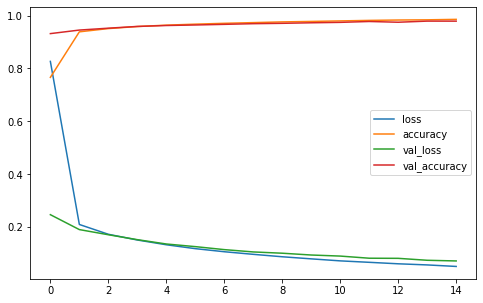

In [43]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

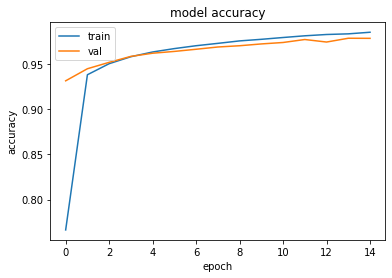

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

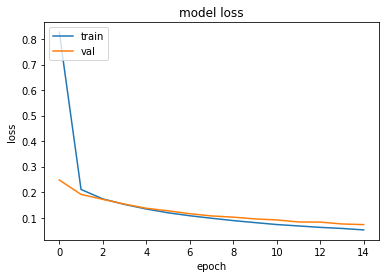

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# functional

In [ ]:
X_train1, Y_train1 = read_hoda_dataset(dataset_path='Train 60000.cdb', images_height=32, images_width=32, one_hot=False, reshape=True)

In [110]:
X_test1, Y_test1 = read_hoda_dataset(dataset_path='Test 20000.cdb', images_height=32, images_width=32, one_hot=False, reshape=True)

In [80]:
X_validation1 = X_train1[50000:]
Y_validation1 = Y_train1[50000:]
X_train1 = X_train1[:50000]
Y_train1 = Y_train1[:50000]

In [81]:
X_test1, X_train1, X_validation1 = X_test1/255, X_train1/255, X_train1/255

In [ ]:
X_test1 = X_test1.reshape(X_test1.shape[0], 32, 32)

In [83]:
visible = keras.Input(shape=(1024,))
hidden1 = layers.Dense(250, activation="relu")(visible)
hidden2 = layers.Dense(150, activation="relu")(hidden1)
hidden3 = layers.Dense(100, activation="relu")(hidden2)
concat = layers.concatenate([visible, hidden3])
output = layers.Dense(10, activation="softmax")(concat)
model2 = keras.Model(inputs=visible, outputs=output)

In [84]:
model2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 dense_31 (Dense)               (None, 250)          256250      ['input_8[0][0]']                
                                                                                                  
 dense_32 (Dense)               (None, 150)          37650       ['dense_31[0][0]']               
                                                                                                  
 dense_33 (Dense)               (None, 100)          15100       ['dense_32[0][0]']               
                                                                                            

In [85]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [86]:
history = model2.fit(X_train1, Y_train1, epochs=15, validation_data=(X_validation1, Y_validation1))

Epoch 1/15
1407/1407 [==============================] - 12s 8ms/step - loss: 0.4543 - accuracy: 0.8612 - val_loss: 0.2051 - val_accuracy: 0.9419
Epoch 2/15
1407/1407 [==============================] - 11s 8ms/step - loss: 0.1703 - accuracy: 0.9515 - val_loss: 0.1467 - val_accuracy: 0.9581
Epoch 3/15
1407/1407 [==============================] - 10s 7ms/step - loss: 0.1171 - accuracy: 0.9666 - val_loss: 0.1066 - val_accuracy: 0.9699
Epoch 4/15
1407/1407 [==============================] - 11s 8ms/step - loss: 0.0856 - accuracy: 0.9754 - val_loss: 0.0965 - val_accuracy: 0.9721
Epoch 5/15
1407/1407 [==============================] - 11s 8ms/step - loss: 0.0676 - accuracy: 0.9806 - val_loss: 0.0784 - val_accuracy: 0.9775
Epoch 6/15
1407/1407 [==============================] - 12s 8ms/step - loss: 0.0530 - accuracy: 0.9841 - val_loss: 0.0672 - val_accuracy: 0.9794
Epoch 7/15
1407/1407 [==============================] - 11s 8ms/step - loss: 0.0433 - accuracy: 0.9875 - val_loss: 0.0609 - val_ac

In [ ]:
predictions1 = model2.predict(X_test1)

In [108]:
Y_predict1 = predictions1.argmax(axis=1)
Y_predict1 = predictions1.argmax(axis=-1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test1, Y_predict1))

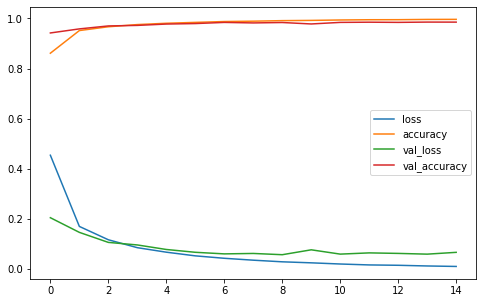

In [100]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

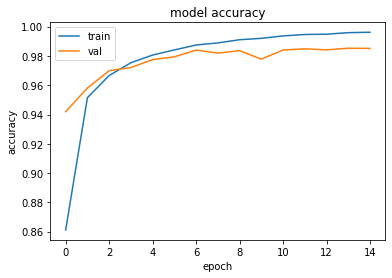

In [101]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

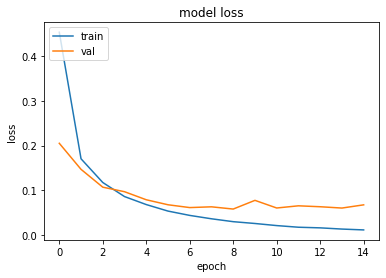

In [102]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()